In [11]:
import numpy as np
import pandas as pd
import torch

torch.set_default_tensor_type(torch.FloatTensor)  # set the default to float32

from rct_data_generator import *
from outcome_models import *
from plotting_functions import *
from mcmc_bayes_update import *
from eig_comp_utils import *

### 1. Simulating the data

In [12]:
rng = np.random.RandomState(42)
n_rct_before_split = 10**4
n_host = 200  # number of samples in the host dataset?

## NUMBER of sample for candidate datasets
# Candidate 1 is the mirror image of host
n_mirror = 500
n_cand2 = 500

# what are these?
sigma_prior = 1.0
sigma_rand_error = 1.0
power_x, power_x_t = 1, 1  # ??
causal_param_first_index = 3
std_true_y = 0.01  # Standard deviation for the true Y

In [33]:
# outcome_function = lambda X, T, eps: 1 + 1 * X[:,0] - 1 * X[:,1] + 1 * T + 1* X[:,0]*T + -1* X[:,1]*T + eps
# p_assigned_to_host = lambda X_1, X_2, T, eps: sigmoid(1 + 2 * X_1 - X_2 + T + eps)
# p_assigned_to_cand2 = lambda X_1, X_2, T, eps: sigmoid(1 - 2 * X_1 + eps)
def outcome_function(X: np.ndarray, T: np.ndarray, eps: np.ndarray) -> np.ndarray:
    # y = intercept + 1*X_0 - 1*X_1 + 1*T + 1*X_0*T - 1*X_1*T + noise
    assert X.shape[0] == T.shape[0] == eps.shape[0], "Shape mismatch"
    return (
        1.0
        + 1.0 * X[:, 0]
        - 1.0 * X[:, 1]
        + 1.0 * T
        + 1.0 * X[:, 0] * T
        - 1.0 * X[:, 1] * T
        + eps
    )


def p_assigned_to_host(X_1, X_2, T, eps):
    # ??
    return sigmoid(1.0 + 2.0 * X_1 - X_2 + T + eps)


def p_assigned_to_cand2(X_1, X_2, T, eps):
    # ??
    return sigmoid(1.0 - 2.0 * X_1 + eps)

In [34]:
X0 = np.random.randint(0, 2, size=n_rct_before_split)
X1 = np.random.normal(size=n_rct_before_split)
x_distributions = {0: X0, 1: X1}  # distributions of covariates?

In [35]:
# is this the whole "population"?
X_rct, T_rct = generate_rct(n_rct_before_split, x_distributions)
print(X_rct.shape, T_rct.shape)

(10000, 2) (10000,)


In [36]:
design_data_host, design_data_mirror = generate_host_and_mirror(
    X=X_rct,
    T=T_rct,
    f_assigned_to_host=p_assigned_to_cand2,
    n_host=n_host,
    n_mirror=n_mirror,
    power_x=power_x,
    power_x_t=power_x_t,
    outcome_function=outcome_function,
    std_true_y=std_true_y,
)  # two data frames: host and "mirror"
print(design_data_host.head(3))  # [n_host, how many and what are the cols??]
# should be the same as host but reversed treatment?
print(design_data_mirror.head(3))  # [n_mirror, how many and what are the cols??]

   intercept   X0        X1  T  T*X0      T*X1         Y
0        1.0  1.0  2.976466  0   0.0  0.000000  0.983934
1        1.0  0.0 -0.703661  1   0.0 -0.703661  3.994097
2        1.0  0.0 -0.509006  1   0.0 -0.509006  3.987352
   intercept   X0        X1  T  T*X0      T*X1         Y
0        1.0  1.0 -0.220907  1   1.0 -0.220907  1.993787
1        1.0  1.0  0.934841  1   1.0  0.934841  2.007558
2        1.0  1.0  0.724814  0   0.0  0.000000  0.986771


In [37]:
pre_X_cand2, pre_T_cand2 = generate_rct(n_rct_before_split, x_distributions)
design_data_cand2 = generate_cand2(
    X=pre_X_cand2,
    T=pre_T_cand2,
    f_assigned_to_cand2=p_assigned_to_cand2,
    n_cand2=n_cand2,
    power_x=power_x,
    power_x_t=power_x_t,
    outcome_function=outcome_function,
    std_true_y=std_true_y,
)

In [38]:
X_mirror, Y_mirror = design_data_mirror.drop(columns=["Y"]), design_data_mirror["Y"]
X_cand2, Y_cand2 = design_data_cand2.drop(columns=["Y"]), design_data_cand2["Y"]

### 2. Simulating from prior and plotting
Note: I don't think this is the right way to compare if our estimates are getting better but it will do for now

In [40]:
# Initialize prior parameters
post_mean = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])  # is this prior??

beta_0, sigma_0_sq, inv_cov_0 = (
    post_mean,
    sigma_rand_error**2,
    1 / sigma_prior * np.eye(len(post_mean)),
)
prior_hyperparameters = {
    "beta_0": beta_0,
    "sigma_0_sq": sigma_0_sq,
    "inv_cov_0": inv_cov_0,
}
bayes_reg = BayesianLinearRegression(prior_hyperparameters)

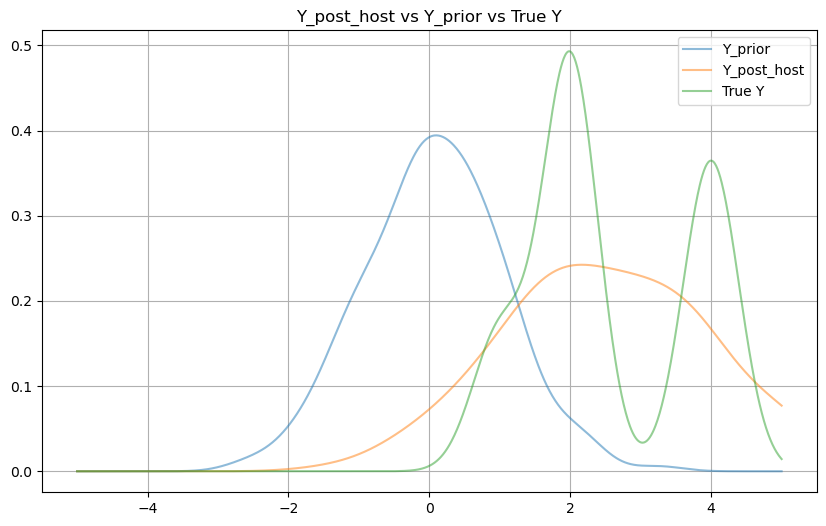

In [41]:
### Bayesian update through host dataset
X_host, Y_host = design_data_host.drop(columns=["Y"]), design_data_host["Y"]
post_host_parameters = bayes_reg.fit(np.array(X_host.values), np.array(Y_host.values))

# Generate Y_prior
Y_prior = np.dot(X_host, beta_0) + np.random.normal(0, sigma_rand_error, len(X_host))

# Generate Y_post_host
beta_post_host_vec = post_host_parameters[
    "posterior_mean"
].flatten()  # Extract posterior mean
cov_matrix_post_host = post_host_parameters["posterior_cov_matrix"]
Y_post_host = np.dot(X_host, beta_post_host_vec) + np.random.normal(
    0, 1, len(X_host)
)  # Assuming standard deviation for Y_post_host is 1

plot_densities(
    Y_prior,
    Y_post_host,
    design_data_host["Y"],
    names=["Y_prior", "Y_post_host", "True Y"],
    title="Y_post_host vs Y_prior vs True Y",
)

In [7]:
# ### Bayesian update through candidate datasets
# sigma_cand = 1
# prior_hyperparameters_cand = {'beta_0': beta_post_host_vec, 'sigma_0_sq': sigma_cand}

# ## With candidate = mirror dataset
# bayes_reg_mirror = BayesianLinearRegression(prior_hyperparameters_cand)
# X_mirror, Y_mirror = design_data_mirror.drop(columns=['Y']), design_data_mirror['Y']
# post_mirror_parameters = bayes_reg_mirror.fit(X_mirror, Y_mirror)

# # Generate Y_post_mirror
# post_mirror_mean = post_mirror_parameters['posterior_mean'].flatten()  # Extract posterior mean
# Y_post_mirror = np.dot(X_mirror, post_mirror_mean) + np.random.normal(0, 1, len(X_mirror))  # Assuming standard deviation for Y_post_host is 1

# ## With candidate = cand2 dataset
# bayes_reg_cand2 = BayesianLinearRegression(prior_hyperparameters_cand)
# X_cand2, Y_cand2 = design_data_cand2.drop(columns=['Y']), design_data_cand2['Y']
# post_cand2_parameters = bayes_reg_cand2.fit(X_cand2, Y_cand2)

# # Generate Y_post_cand2
# post_cand2_mean = post_cand2_parameters['posterior_mean'].flatten()  # Extract posterior mean
# Y_post_cand2 = np.dot(X_cand2, post_cand2_mean) + np.random.normal(0, 1, len(X_cand2))  # Assuming standard deviation for Y_post_host is 1

# plot_densities(Y_post_mirror, Y_post_cand2, design_data_host['Y'],
#                 names = ['Y_post_mirror', 'Y_post_cand2', 'True Y'],
#                 title = 'Y_post_mirror vs Y_post_cand2 vs True Y')

In [42]:
# Number of samples used to estimate outer expectation
n_samples_for_expectation = 100
m_samples_for_expectation = int(np.ceil(np.sqrt(n_samples_for_expectation)))
# Incorporating sqrt constraint into MCMC samples
n_mcmc = n_samples_for_expectation * (m_samples_for_expectation + 1)

warmup_steps = 10
max_tree_depth = 7
sigma_rand_error = sigma_0_sq

X_torch = torch.tensor(X_host.values)
Y_torch = torch.tensor(Y_host.values)

## Bayesian update using the host dataset
mcmc_host = MCMC_Bayesian_update(
    X_torch=X_torch,
    Y_torch=Y_torch,
    model=model_normal,
    mu_0=beta_0,
    sigma_prior=sigma_prior,
    sigma_rand_error=sigma_rand_error,
    sigma_rand_error_fixed=True,
    n_mcmc=n_mcmc,
    warmup_steps=warmup_steps,
    max_tree_depth=max_tree_depth,
)
mcmc_host.summary()

beta_post_host = pd.DataFrame(mcmc_host.get_samples())

# Shuffling to remove any dependence between adjacent samples
beta_post_host = beta_post_host.sample(frac=1)

beta_post_host.head()
# We delete the column with the std
beta_post_host_without_std = beta_post_host.iloc[:, :-1]

Warmup:   0%|          | 0/1110 [00:00, ?it/s]

Sample: 100%|██████████| 1110/1110 [00:34, 31.88it/s, step size=5.11e-02, acc. prob=0.916]


Inference ran for 0.58 minutes

                mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta_0      2.00      0.13      2.00      1.79      2.20    670.22      1.00
    beta_1     -0.98      0.20     -0.99     -1.34     -0.67    395.87      1.00
    beta_2     -0.00      0.10     -0.00     -0.16      0.14    913.13      1.00
    beta_3      1.96      0.17      1.97      1.68      2.24    623.26      1.00
    beta_4     -0.95      0.28     -0.95     -1.41     -0.50    340.80      1.00
    beta_5      0.00      0.13      0.01     -0.21      0.23    619.61      1.00

Number of divergences: 0


In [50]:
print(beta_post_host.describe())
# what's the true??
print(beta_post_host_vec)

            beta_0       beta_1       beta_2       beta_3       beta_4  \
count  1100.000000  1100.000000  1100.000000  1100.000000  1100.000000   
mean      1.996781    -0.983563    -0.002950     1.964813    -0.948628   
std       0.126571     0.202631     0.096163     0.173467     0.276310   
min       1.610035    -1.552340    -0.337226     1.376790    -1.761126   
25%       1.913366    -1.127989    -0.068099     1.844846    -1.125539   
50%       1.999231    -0.988671    -0.004640     1.965751    -0.945705   
75%       2.081393    -0.849883     0.064869     2.082660    -0.776097   
max       2.467403    -0.346741     0.304913     2.568251     0.080923   

            beta_5  
count  1100.000000  
mean      0.003144  
std       0.134038  
min      -0.410791  
25%      -0.090208  
50%       0.007703  
75%       0.093744  
max       0.410847  
[ 1.99683761e+00 -9.93564122e-01 -7.08350210e-04  1.96103500e+00
 -9.38668629e-01 -2.35969185e-03]


In [44]:
beta_post_host.cov()

,beta_0,beta_1,beta_2,beta_3,beta_4,beta_5
beta_0,0.016020,-0.014688,0.001558,-0.015866,0.014678,-0.001956
beta_1,-0.014688,0.041059,0.000608,0.013694,-0.039267,-0.001510
beta_2,0.001558,0.000608,0.009247,-0.002373,0.000625,-0.009742
beta_3,-0.015866,0.013694,-0.002373,0.030091,-0.028349,0.003515
beta_4,0.014678,-0.039267,0.000625,-0.028349,0.076347,-0.002255
beta_5,-0.001956,-0.001510,-0.009742,0.003515,-0.002255,0.017966


In [45]:
pd.DataFrame(beta_post_host.cov() - cov_matrix_post_host)

,beta_0,beta_1,beta_2,beta_3,beta_4,beta_5
beta_0,-0.000295,0.000537,0.000455,0.000025,0.000266,-0.000899
beta_1,0.000537,-0.002768,0.000396,-0.000743,0.002648,-0.001206
beta_2,0.000455,0.000396,0.000306,-0.001286,0.000861,-0.000867
beta_3,0.000025,-0.000743,-0.001286,0.001068,-0.001410,0.002076
beta_4,0.000266,0.002648,0.000861,-0.001410,-0.002761,-0.000568
beta_5,-0.000899,-0.001206,-0.000867,0.002076,-0.000568,0.001732


### 3. Calculating EIG observational

For the mirror dataset

First, we calculate EIG using samples by getting the model predictions and putting them in the correct form

In [13]:
X_mirror_arr = X_mirror.values
Y_pred_mirror = predict_with_all_sampled_linear(beta_post_host, X_mirror_arr)

pred_list_mirror = predictions_in_EIG_obs_form(
    Y_pred_mirror, n_samples_for_expectation, m_samples_for_expectation
)

In [14]:
compute_EIG_obs_from_samples(pred_list_mirror, sigma_rand_error)

6.2143311819169185

Now to calculate for the causal

In [15]:
sample_func = return_causal_samp_func_linear(
    X=X_torch,
    Y=Y_torch,
    causal_param_first_index=3,
    mu_0=beta_0,
    sigma_prior=sigma_prior,
    sigma_rand_error=sigma_rand_error,
    sigma_rand_error_fixed=True,
    warmup_steps=warmup_steps,
    max_tree_depth=max_tree_depth,
)
pred_func = lambda beta: beta @ (X_mirror).T

In [16]:
# pred_in_causal_form = predictions_in_EIG_causal_form(pred_func, theta_samples=beta_post_host.values[:40], theta_sampling_function=sample_func, n_non_causal_expectation=100, causal_param_first_index=3)

In [17]:
# compute_EIG_causal_from_samples(pred_list_mirror,pred_in_causal_form, sigma_rand_error)

Now, trying to calculate in closed form

In [18]:
compute_EIG_obs_closed_form(X_mirror_arr, cov_matrix_post_host, sigma_rand_error)

3.8274889813495943

In [19]:
compute_EIG_causal_closed_form(X_mirror_arr, cov_matrix_post_host, sigma_rand_error, 3)

0.9947338527725553

For the cand2 dataset

In [20]:
X_cand2_arr = X_cand2.values
Y_pred_cand2 = predict_with_all_sampled_linear(beta_post_host, X_cand2_arr)

pred_list_cand2 = predictions_in_EIG_obs_form(
    Y_pred_cand2, n_samples_for_expectation, m_samples_for_expectation
)

In [21]:
compute_EIG_obs_from_samples(pred_list_cand2, sigma_rand_error)

8.01836274625009

Now, trying to calculate in closed form

In [94]:
compute_EIG_obs_closed_form(X_cand2_arr, cov_matrix_post_host, sigma_rand_error)

3.6900844875155885

In [95]:
compute_EIG_causal_closed_form(X_cand2_arr, cov_matrix_post_host, sigma_rand_error, 3)

1.0969206417854989

### Sanity Experiments

In [96]:
from scipy.stats import multivariate_normal

In [97]:
mvn = multivariate_normal(mean=beta_post_host_vec, cov=cov_matrix_post_host)

In [98]:
n_samples_for_expectation = 2000
m_samples_for_expectation = int(np.ceil(np.sqrt(n_samples_for_expectation)))

In [99]:
beta = mvn.rvs(n_samples_for_expectation * (m_samples_for_expectation + 1))

In [100]:
beta.shape

(92000, 6)

In [101]:
sigma_rand_error = 1

In [102]:
y_pred_vec = predict_with_all_sampled_linear(pd.DataFrame(beta), X_mirror_arr)

In [103]:
y_pred_form = predictions_in_EIG_obs_form(
    y_pred_vec, n_samples_for_expectation, m_samples_for_expectation
)

In [104]:
compute_EIG_obs_from_samples(y_pred_form, sigma_rand_error)

5.049881177021348

In [105]:
calc_posterior_predictive_entropy(y_pred_form, sigma_rand_error)

Sample:  21%|██        | 232/1110 [00:21, 110.29it/s, step size=4.74e-02, acc. prob=0.942]

713.9648671493129

In [106]:
compute_EIG_obs_closed_form(X_mirror_arr, cov_matrix_post_host, sigma_rand_error)

3.6701673232749767

In [107]:
n_e = len(y_pred_form[0][0])
X = X_mirror_arr
sign, log_det_term = np.linalg.slogdet(
    X @ ((cov_matrix_post_host) @ X.T) + (sigma_rand_error**2) * np.eye(n_e)
)
1 / 2 * log_det_term + n_e / 2 * (1 + np.log(2 * np.pi))

713.1394339256113

In [108]:
beta_repeat = np.tile(beta_post_host_vec, (len(beta), 1))

In [109]:
y_pred_vec_repeat = predict_with_all_sampled_linear(
    pd.DataFrame(beta_repeat), X_mirror_arr
)

In [110]:
y_pred_vec.shape

(92000, 500)

In [111]:
y_pred_vec_repeat.shape

(92000, 500)

In [112]:
y_pred_form_repeat = predictions_in_EIG_obs_form(
    y_pred_vec_repeat, n_samples_for_expectation, m_samples_for_expectation
)

In [113]:
cov_matrix_post_host_zero = np.zeros_like(cov_matrix_post_host)

In [114]:
sigma_repeat = 0.0001

In [115]:
compute_EIG_obs_from_samples(y_pred_form_repeat, sigma_repeat)

-0.2012644936221477

In [116]:
compute_EIG_obs_closed_form(X_mirror_arr, cov_matrix_post_host_zero, sigma_repeat)

-9.094947017729282e-12

In [117]:
n_e = len(y_pred_form_repeat[0][0])
X = X_mirror_arr
sign, log_det_term = np.linalg.slogdet(
    X @ ((cov_matrix_post_host_zero) @ X.T) + (sigma_repeat**2) * np.eye(n_e)
)
1 / 2 * log_det_term + n_e / 2 * (1 + np.log(2 * np.pi))

-3895.700919385764

In [118]:
calc_posterior_predictive_entropy(y_pred_form_repeat, sigma_repeat)

-3895.6722024874466

In [119]:
cov_matrix_post_host_id = np.eye(6)
mvn_id = multivariate_normal(mean=beta_post_host_vec, cov=cov_matrix_post_host_id)
n_samples_for_expectation = 500
m_samples_for_expectation = int(np.ceil(np.sqrt(n_samples_for_expectation)))
beta_id = mvn_id.rvs(n_samples_for_expectation * (m_samples_for_expectation + 1))

In [120]:
sigma_rand_error = 1

In [121]:
y_pred_vec_id = predict_with_all_sampled_linear(pd.DataFrame(beta_id), X_mirror_arr)
y_pred_form_id = predictions_in_EIG_obs_form(
    y_pred_vec_id, n_samples_for_expectation, m_samples_for_expectation
)

In [122]:
compute_EIG_obs_from_samples(y_pred_form_id, sigma_rand_error)

360.17254162456425

In [123]:
sign, log_det_term = np.linalg.slogdet(
    X_mirror_arr.T @ X_mirror_arr + cov_matrix_post_host
)
log_det_term

30.066570743698733

In [124]:
sign, log_det_term = np.linalg.slogdet(
    X_mirror_arr @ (cov_matrix_post_host @ X_mirror_arr.T) + np.eye(len(X_mirror_arr))
)
log_det_term

7.3403346465499535

In [125]:
compute_EIG_obs_closed_form(X_mirror_arr, cov_matrix_post_host_id, sigma_rand_error)

15.080597854446653

Below calculates from samples

In [126]:
calc_posterior_predictive_entropy(y_pred_form_id, sigma_rand_error)

1070.4829435254615

Closed form of same term

In [127]:
n_e = len(y_pred_form_repeat[0][0])
X = X_mirror_arr
sign, log_det_term = np.linalg.slogdet(
    X @ ((cov_matrix_post_host_id) @ X.T) + (sigma_rand_error**2) * np.eye(n_e)
)
1 / 2 * log_det_term + n_e / 2 * (1 + np.log(2 * np.pi))

724.549864456783

In [128]:
n_e / 2 * (1 + np.log(2 * np.pi))

709.4692666023363

In [129]:
sign, log_det = np.linalg.slogdet(X @ ((100000 * cov_matrix_post_host_id) @ X.T))
log_det

-10185.749338094736

In [130]:
np.linalg.det(X @ ((cov_matrix_post_host_id) @ X.T))

-0.0

In [131]:
pred_list = y_pred_form_id
sigma = sigma_rand_error
n_e = len(pred_list[0][0])
covariance = cov.CovViaDiagonal(sigma**2 * np.ones(n_e))
sample_list = []

for y_pred, y_pred_multiple in pred_list:
    mvn = multivariate_normal(mean=y_pred, cov=covariance)
    y_sample = mvn.rvs()
    sample_list.append(log_posterior_predictive(y_sample, y_pred_multiple, covariance))

In [ ]:
pred_list = y_pred_form_id
sigma = sigma_rand_error
n_e = len(pred_list[0][0])
covariance = cov.CovViaDiagonal(sigma**2 * np.ones(n_e))
sample_list = []

for y_pred, y_pred_multiple in pred_list:
    mvn = multivariate_normal(mean=y_pred, cov=covariance)
    y_sample = mvn.rvs()
    sample_list.append(log_posterior_predictive(y_sample, y_pred_multiple, covariance))

In [150]:
mvn = multivariate_normal(mean=y_pred_vec_id[0], cov=covariance)
y_sample = mvn.rvs()

In [151]:
y = y_sample
y_pred_theta_samples = y_pred_vec_id[1:]
n_e = len(y)

log_likelihood_list = []
for y_pred in y_pred_theta_samples:
    log_likelihood_list.append(
        multivariate_normal_log_likelihood(y, y_pred, covariance)
    )
lsum = logsumexp(log_likelihood_list)

In [152]:
max(log_likelihood_list)

-739.3374130390305

In [144]:
lsum + np.log(len(log_likelihood_list))

-1093.7017073821157

In [135]:
prior_matrix = np.eye(6)

In [136]:
sign, log_det_term_post = np.linalg.slogdet(
    (1 / sigma**2) * X_host.T @ X_host + np.linalg.inv(prior_matrix)
)
sign, log_det_term_prior = np.linalg.slogdet(np.linalg.inv(prior_matrix))
1 / 2 * log_det_term_post - 1 / 2 * log_det_term_prior

26.286291705017188